In [8]:
import supervision as sv
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [2]:
keypoints = np.array([[[688.0, 788.0],
                      [691.0, 777.0],
                      [695.0, 781.0],
                      [706.0, 784.0],
                      [734.0, 794.0],
                      [686.0, 820.0],
                      [741.0, 849.0],
                      [623.0, 806.0],
                      [678.0, 853.0],
                      [578.0, 768.0],
                      [608.0, 784.0],
                      [668.0, 967.0],
                      [712.0, 974.0],
                      [582.0, 926.0],
                      [645.0, 950.0],
                      [525.0, 1010.0],
                      [592.0, 1023.0]]], dtype=np.float32)

In [9]:
def compute_trajectory_similarities(history, new_points, window_size=5):
    """Compare movement trajectories over multiple frames"""
    if len(history) < window_size:
        return None
    
    # Calculate trajectory vectors (movement over multiple frames)
    history_trajectory = history[-1] - history[-window_size]  # Total movement over window
    new_trajectory = new_points - history[-window_size]       # Movement from start of window to new points
    
    # For velocity changes (acceleration), we can look at sequential differences
    history_velocities = np.diff(history[-window_size:], axis=0)  # Shape: (window_size-1, 1, 17, 2)
    new_velocity = new_points - history[-1]
    
    # Flatten for similarity calculations
    history_trajectory_flat = history_trajectory.reshape(-1)
    new_trajectory_flat = new_trajectory.reshape(-1)
    
    # 1. Overall trajectory similarity (cosine)
    trajectory_cos_sim = np.dot(history_trajectory_flat, new_trajectory_flat) / (
        np.linalg.norm(history_trajectory_flat) * np.linalg.norm(new_trajectory_flat) + 1e-8
    )
    
    # 2. Average velocity magnitude
    avg_history_velocity = np.mean(np.linalg.norm(history_velocities.reshape(window_size-1, -1), axis=1))
    new_velocity_magnitude = np.linalg.norm(new_velocity.reshape(-1))
    velocity_ratio = new_velocity_magnitude / (avg_history_velocity + 1e-8)
    
    # 3. Cumulative distance traveled
    history_cumulative_distance = np.sum(np.linalg.norm(history_velocities.reshape(window_size-1, -1), axis=1))
    
    return {
        'trajectory_similarity': trajectory_cos_sim,
        'velocity_ratio': velocity_ratio,
        'cumulative_distance': history_cumulative_distance
    }

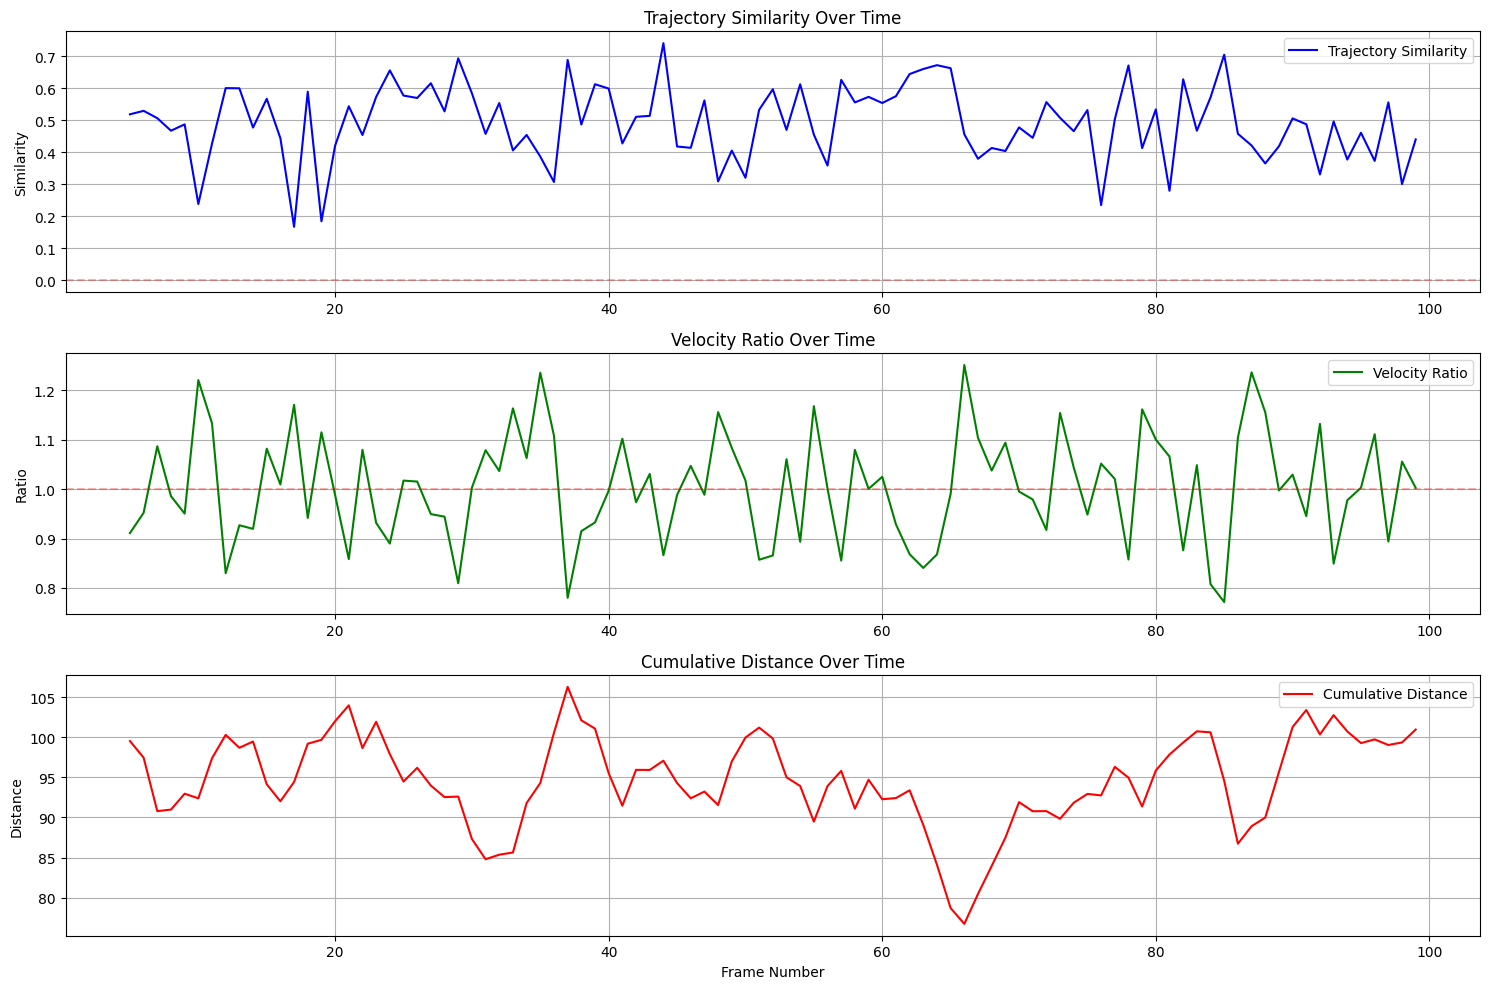

In [12]:
initial_keypoints = keypoints.copy()

# Parameters
movement_scale = 5.0  # Random movement scale
upward_speed = 3.0    # Pixels per frame moving upward
history_size = 5

# Parameters for random movement
movement_scale = 5.0  # Maximum pixels to move in any direction
num_frames = 100
window_size = 5

# Initialize lists to store metrics over time
trajectory_similarities = []
velocity_ratios = []
cumulative_distances = []
frame_numbers = []


# Pre-allocate the history array with shape (history_size, 1, 17, 2)
keypoints_history = np.zeros((history_size,) + initial_keypoints.shape, dtype=np.float32)

num_frames = 100
for i in range(num_frames):
    # Create biased movement: random in x, upward bias in y
    random_movement = np.zeros_like(keypoints)
    random_movement[..., 0] = np.random.uniform(-movement_scale, movement_scale, size=keypoints[..., 0].shape)  # x coordinates
    random_movement[..., 1] = np.random.uniform(-movement_scale, movement_scale, size=keypoints[..., 1].shape) - upward_speed  # y coordinates (negative for upward movement)
    
    new_keypoints = initial_keypoints + random_movement
    
    # Compare trajectories
    if i >= window_size:
        similarities = compute_trajectory_similarities(keypoints_history, new_keypoints, window_size)
        # Store metrics
        trajectory_similarities.append(similarities['trajectory_similarity'])
        velocity_ratios.append(similarities['velocity_ratio'])
        cumulative_distances.append(similarities['cumulative_distance'])
        frame_numbers.append(i)
    
    # Update history
    keypoints_history = np.roll(keypoints_history, -1, axis=0)
    keypoints_history[-1] = new_keypoints


# Create plots
plt.figure(figsize=(15, 10))

# Trajectory Similarity Plot
plt.subplot(3, 1, 1)
plt.plot(frame_numbers, trajectory_similarities, 'b-', label='Trajectory Similarity')
plt.axhline(y=0, color='r', linestyle='--', alpha=0.3)
plt.ylabel('Similarity')
plt.title('Trajectory Similarity Over Time')
plt.legend()
plt.grid(True)

# Velocity Ratio Plot
plt.subplot(3, 1, 2)
plt.plot(frame_numbers, velocity_ratios, 'g-', label='Velocity Ratio')
plt.axhline(y=1, color='r', linestyle='--', alpha=0.3)
plt.ylabel('Ratio')
plt.title('Velocity Ratio Over Time')
plt.legend()
plt.grid(True)

# Cumulative Distance Plot
plt.subplot(3, 1, 3)
plt.plot(frame_numbers, cumulative_distances, 'r-', label='Cumulative Distance')
plt.ylabel('Distance')
plt.xlabel('Frame Number')
plt.title('Cumulative Distance Over Time')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
